In [92]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import mean_squared_error, accuracy_score,r2_score
from sklearn.model_selection import TimeSeriesSplit
import holidays
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from datetime import timedelta
from sklearn.linear_model import LinearRegression
import plotly.graph_objects as go 
import plotly.io as periods
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math

In [93]:
def sin_cos_transform(series, divisor=-1):
    """
    Apply sin cos transformation to get cyclical features.

    Args:
        series (iterable): Series to transform
        divisor (int): Divisor value. If it doesn't set, function gets max value of series.

    Returns:
        - sin_values (list) - Sin transformed values
        - cos_values (list) - Cos transformed values
    """
    if divisor == -1:
        divisor = series.max()
    sin_values = [math.sin((2 * math.pi * x) / divisor) for x in list(series)]
    cos_values = [math.cos((2 * math.pi * x) / divisor) for x in list(series)]
    return sin_values, cos_values

In [94]:
# Function to check if a date is a US holiday
def is_us_holiday(date):
    us_holidays = holidays.US(years=date.year)
    return date in us_holidays


def create_features(df):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    
    df["day_of_week_sin"], df["day_of_week_cos"] = sin_cos_transform(df.index.dayofweek, divisor=7)
    df["day_of_month_sin"], df["day_of_month_cos"] = sin_cos_transform(df.index.day, divisor=30)
    df["month_sin"], df["month_cos"] = sin_cos_transform(df.index.month, divisor=12)


    df['day_of_quarter'] = (df.index.dayofyear - 1) % 91 + 1
    df['week_of_month'] = df.index.day // 7 + 1
    df['quarter_of_year'] = df.index.quarter
    df['week_of_year'] = df.index.isocalendar().week.astype('int32')
    df["is_wknd"] = df.index.weekday // 5
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['season'] = df['month'] % 12 // 3 + 1
    df['lag7_births'] = df['births'].shift(periods=7)
    df['lag14_births'] = df['births'].shift(periods=14)
    df['lag4_births'] = df['births'].shift(periods=4)
    df['lag6_births'] = df['births'].shift(periods=6)
    df['births_diff7'] = df['births'].shift(7) - df['births'].shift(14)
    window_size = 7
    df['rolling_std'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").std()

    # Calculate the rolling mean, max, and min for the relevant columns
    df['rolling_mean'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").mean()
    df['rolling_max'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").max()
    df['rolling_min'] = df['births'].rolling(window=window_size, min_periods=1, closed= "left").min()
    # Add 'is_us_holiday' column to DataFrame
    df['is_us_holiday'] = df.index.map(is_us_holiday).astype(int)
    return df


In [95]:
df = pd.read_csv("Births2015.csv")
df = df.drop(columns = ['Unnamed: 0', 'wday'], axis = 1)
df['date'] = pd.to_datetime(df['date'])
df.describe()
df = df.set_index('date')

In [96]:
df =create_features(df)

<Axes: >

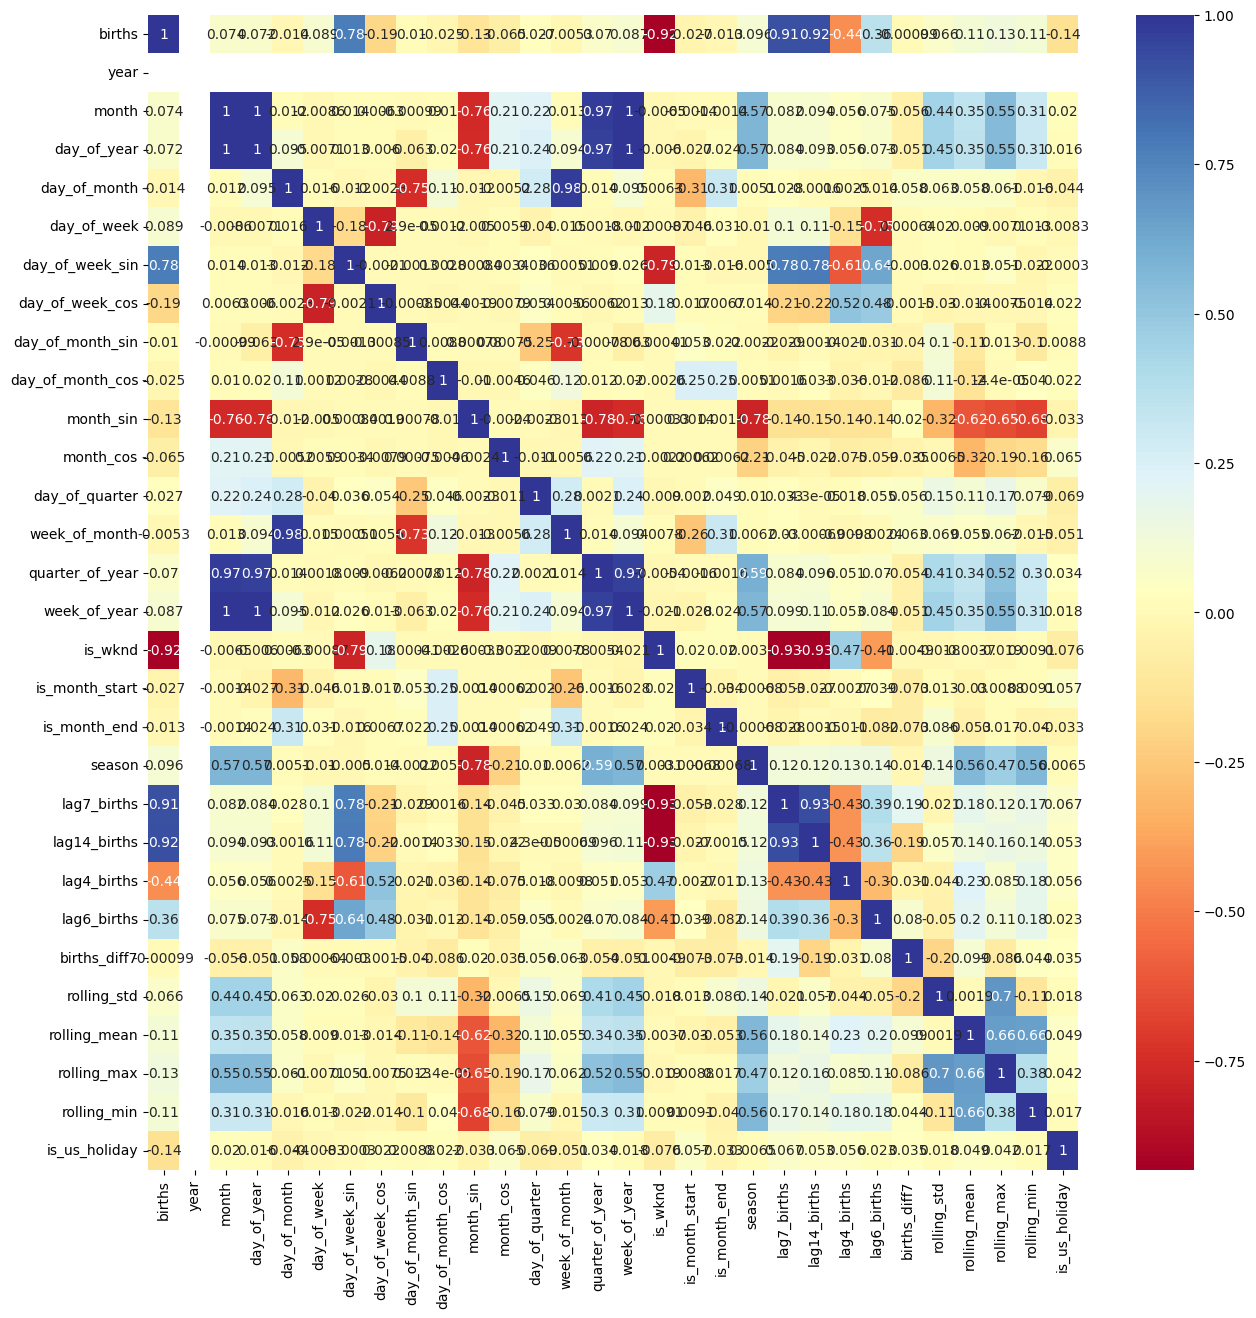

In [97]:
plt.figure(figsize=(15, 15))  # Adjust the size as per your preference
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlBu')

In [98]:
df= df.dropna()

In [99]:
df.columns

Index(['births', 'year', 'month', 'day_of_year', 'day_of_month', 'day_of_week',
       'day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter',
       'week_of_month', 'quarter_of_year', 'week_of_year', 'is_wknd',
       'is_month_start', 'is_month_end', 'season', 'lag7_births',
       'lag14_births', 'lag4_births', 'lag6_births', 'births_diff7',
       'rolling_std', 'rolling_mean', 'rolling_max', 'rolling_min',
       'is_us_holiday'],
      dtype='object')

In [100]:
FEATURES= ['day_of_week_sin', 'day_of_week_cos', 'day_of_month_sin',
       'day_of_month_cos', 'month_sin', 'month_cos', 'day_of_quarter', 'is_wknd',
       'lag7_births', 'lag14_births', 'lag6_births' ,'rolling_std', 'rolling_mean',
       'rolling_max', 'rolling_min', 'is_us_holiday']
TARGET = 'births' 

In [101]:
train = df[:-60]
val = df[-60:-30]
test = df[-30:]

In [102]:
X_train = train[FEATURES]
y_train = train[TARGET]
X_val = val[FEATURES]
y_val = val[TARGET]
X_test = test[FEATURES]
y_test = test[TARGET]

In [103]:

linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

# Step 4: Make predictions on training and validation data
train_preds = linear_reg.predict(X_train)
val_preds = linear_reg.predict(X_val)

# Step 5: Create a Plotly Figure and add traces
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_train).index, y=train_preds, name="train_preds", line=dict(color='blue'))
)

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_val).index, y=val_preds, name="val_preds", line=dict(color='cyan'))
)

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_train).index, y=pd.DataFrame(y_train)["births"], name="train_target", line=dict(color='brown'))
)

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_val).index, y=pd.DataFrame(y_val)["births"], name="val_target", line=dict(color='black'))
)

# Step 6: Update the layout of the plot
fig.update_layout(
    title="Linear Regression Predictions vs. Actual Values",
    xaxis_title="Date",
    yaxis_title="Births",
    height=600,
    legend=dict(x=0.7, y=0.9)
)

# Step 7: Show the plot
fig.show()


In [104]:
print(f"train_MSE: {mse(train_preds, y_train)}")
print(f"train_MAE: {mae(train_preds, y_train)}")
print(f"train_RMSE: { np.sqrt(mean_squared_error(y_train, train_preds))}")
print(f"val_MSE: {mse(val_preds, y_val)}")
print(f"val_MAE: {mae(val_preds, y_val)}")
print(f"val_RMSE: { np.sqrt(mean_squared_error(y_val, val_preds))}")


train_MSE: 133724.5319885545
train_MAE: 246.3411763697554
train_RMSE: 365.68365015208775
val_MSE: 942897.1115461944
val_MAE: 533.8608150425225
val_RMSE: 971.0288932602338


VIF

In [105]:
vif = pd.DataFrame() #Let us show th VIF scores in a data frame
vif['Features'] = df.columns
vif['VIF Factor'] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])] #variance_inflation_factor calculates the scores #for each Feature
vif
#higher values indicate higher multicollinearity between a specific feature and the other features in the dataset.

c:\Users\ipek\Desktop\staj-DATABOSS\MLproject\.env\lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning:

divide by zero encountered in scalar divide



,Features,VIF Factor
0,births,1.856843e+01
1,year,1.153960e+04
2,month,6.453200e+04
3,day_of_year,3.333688e+05
4,day_of_month,5.104297e+02
5,day_of_week,7.476840e+01
6,day_of_week_sin,7.831495e+00
7,day_of_week_cos,1.632807e+02
8,day_of_month_sin,3.531230e+00
9,day_of_month_cos,1.331601e+00


FEATURE IMPORTANCE

Feature: day_of_week_sin, Score: 455.96046
Feature: day_of_week_cos, Score: 44.03098
Feature: day_of_month_sin, Score: 1.80239
Feature: day_of_month_cos, Score: -60.66664
Feature: month_sin, Score: -64.97706
Feature: month_cos, Score: -43.68611
Feature: day_of_quarter, Score: -0.97428
Feature: is_wknd, Score: -2639.02913
Feature: lag7_births, Score: 0.23406
Feature: lag14_births, Score: 0.08555
Feature: lag6_births, Score: -0.12847
Feature: rolling_std, Score: 0.78943
Feature: rolling_mean, Score: -0.07140
Feature: rolling_max, Score: -0.00627
Feature: rolling_min, Score: 0.76542
Feature: is_us_holiday, Score: -1848.60220


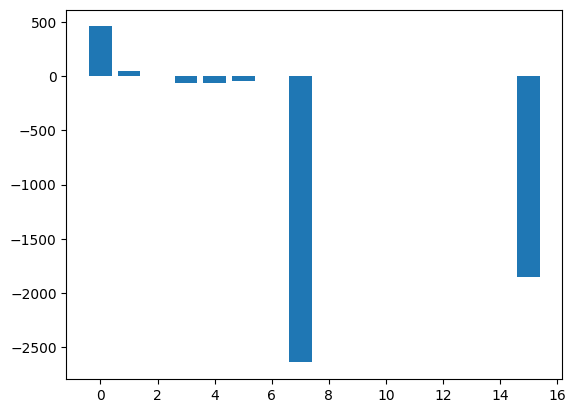

In [106]:
# get importance
importance = linear_reg.coef_
# summarize feature importance
for i,v in enumerate(importance):
 print('Feature: %s, Score: %.5f' % (FEATURES[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

FORECASTING

In [107]:
# Step 3: Make predictions on the test data
test_preds = linear_reg.predict(X_test)

fig = go.Figure()

fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_test).index, y=test_preds, name="test_preds", line=dict(color='orange'))
)


fig.add_trace(
    go.Scatter(x=pd.DataFrame(y_test).index, y=pd.DataFrame(y_test)["births"], name="test_vals", line=dict(color='black'))
)

fig.update_layout(
    title="Forecasting Test Set",
    xaxis_title="Date",
    yaxis_title="Births",
    height=600,
    legend=dict(x=0.7, y=0.9)
)

# Step 7: Show the plot
fig.show()

In [108]:
print(f"test_MSE: {mse(test_preds, y_test)}")
print(f"test_MAE: {mae(test_preds, y_test)}")
print(f"test_RMSE: { np.sqrt(mean_squared_error(y_test, test_preds))}")


test_MSE: 1136043.454966714
test_MAE: 611.845589001355
test_RMSE: 1065.853392810997


In [110]:
naive = pd.concat([y_val, y_test])
naive = naive[-37:-7]

rmse2 = np.sqrt(mean_squared_error(y_test, naive))
print("Root Mean Squared Error (RMSE) naive:", rmse2)


Root Mean Squared Error (RMSE) naive: 1798.9476646083956
